# Exploring How to Cluster Documents

More precisely, explore ways to measure **document similarity** and use a simple k-means clustering analysis. This leads to how to **represent a document in a vector format**, then use cosine similarity to compute the similarity.
- tf-idf
- doc2vec
- http://nlp.town/blog/sentence-similarity/

In [1]:
import json
import nlp

from itertools import groupby
from itertools import chain
from collections import Counter
from collections import defaultdict

from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.similarities.docsim import MatrixSimilarity

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

dataset = 'asm' # lss/asm
input_file = '../data/lss-17k.json'
output_file = '../data/lss-17k-clusters.json'

if dataset == 'asm':
    input_file = '../data/lss_asm_dataset.txt'
    output_file = '../data/lss-asm-clusters.json'

## Data Preparation

In [2]:
def load(filename):
    'A text file with each line as a JSON text.'
    p = parse_asm if dataset == 'asm' else parse_lss
    with open(filename) as file:
        sessions = [p(line) for line in file]
        
    return [s for s in sessions if s]

def parse_asm(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actions' in obj and obj['actions'] and len(obj['actions']) <= 150: # limit max length to sync with the vis
        action = [a['name'][6:] for a in obj['actions']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['session']['dcxID'], 'userId': obj['session']['user']['uid'], 'action': action }

def parse_lss(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actionsQueue' in obj and obj['actionsQueue'] and obj['userId'] != 'none' and obj['officeId'] != 'none' and obj['orga'] != 'none':
        action = [a[6:] for a in obj['actionsQueue']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['PFX'], 'userId': obj['userId'], 'action': action }

In [3]:
data = load(input_file)

In [4]:
# def group_one(k, g):
#     return (k, list(chain.from_iterable(s['action'] for s in g)))

# key = lambda x: x['userId']
# groups = groupby(sorted(data, key=key), key=key)
# group_data = [group_one(k, g) for k, g in groups]
# docs = [d[1] for d in group_data]
# len(group_data), docs[0]

docs = [d['action'] for d in data]
len(data), docs[0]

(18957,
 ['SearchUsr',
  'SearchUsr',
  'DisplayOneUser',
  'UpdateUserDetails',
  'TabBar',
  'SearchUsr',
  'DisplayOneUser',
  'UpdateUserDetails',
  'TabBar',
  'TabBar'])

Look at action distribution.

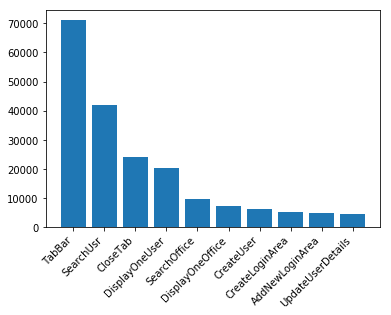

In [27]:
counter = Counter(chain.from_iterable(docs))
common_actions = counter.most_common(10)
plt.bar(range(10), [a[1] for a in common_actions])
plt.xticks(range(10), [a[0] for a in common_actions], rotation=45, ha='right')
plt.show()

Filter out `TabBar` and `CloseTab`.

In [32]:
exclude = ['TabBar', 'CloseTab']
docs = [[a for a in d if a not in exclude] for d in docs]

In [33]:
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

##  TF-IDF

`gensim` has a tfidf model and a matrix similarity that takes on the tfidf-transformed corpus.

In [34]:
tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]
index = MatrixSimilarity(tfidf_corpus, num_features=len(dictionary))
sims = index[tfidf_corpus]

Apply k-means clustering.

In [35]:
def cluster(matrix, n_clusters=10):
    'Cluster the given array of high-dimensional data and return the cluster labels.'
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(matrix)
    return kmeans.labels_

In [36]:
cluster_labels = cluster(sims, n_clusters=10)

Look at the distribution of clusters.

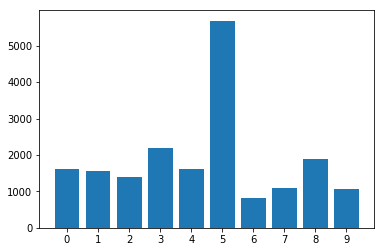

In [38]:
counter = Counter(cluster_labels)
plt.bar(counter.keys(), counter.values())
plt.xticks(range(10), range(10))
plt.show()

A challenging question: what is each cluster about? Let's try top 5 common words in each cluster.
doc -> a vector
a cluster -> a vector?
points distributed around center of the cluster, 5 points near the clusters
common ones or same vector space isn't it?

a vector closet terms to that cluster

In [41]:
def get_docs_for_cluster(id, cluster_labels):
    'Return a list of docs in the given cluster.'
    return [i for i, label in enumerate(cluster_labels) if label == id]

def get_words_for_cluster(id, cluster_labels, dictionary, tfidf_corpus):
    'Return 5 words that represent the given cluster.'
    doc_ids = get_docs_for_cluster(id, cluster_labels)
    lookup = defaultdict(float)
    
    for i in doc_ids:
        for word_id, value in tfidf_corpus[i]:
            lookup[word_id] += value

    top_words = sorted(lookup.items(), key=lambda kv: kv[1], reverse=True)

    return [dictionary[w] for w, v in top_words[:5]]

In [42]:
cluster_details = [get_words_for_cluster(i, cluster_labels, dictionary, tfidf_corpus) for i in range(10)]
cluster_details

[['UpdateUserDetails',
  'DisplayOneUser',
  'NotifyDisplayedUser',
  'SearchUsr',
  'ResetPwdDisplayed'],
 ['DisplayOneUser',
  'SearchUsr',
  'SearchOffice',
  'NotifyDisplayedUser',
  'DisplayOneOffice'],
 ['CreateUser',
  'AssignRole2',
  'AssignRole1',
  'AssignRoleAclConfirmation1',
  'WarningDeleteUser'],
 ['SearchOffice',
  'DisplayOneOffice',
  'SearchUsr',
  'DisplayOneUser',
  'UnLockUser'],
 ['SearchUsr',
  'DisplayOneUser',
  'UnLockUser',
  'UpdateUserDetails',
  'CreateUser'],
 ['ResetPwdUnlock', 'Next', 'DisplayOneUser', 'SearchUsr', 'AssignAcl1'],
 ['DisplayOrgaDetails',
  'ChooseOrganization',
  'DisplayOnePartner',
  'FilterByAppACL',
  'ViewDetailsdod'],
 ['UnLockUser',
  'SearchUsr',
  'ResetPwdUnlock',
  'DisplayOneUser',
  'NotifyDisplayedUser'],
 ['DisplayOneAppli',
  'FilterRolesForApp',
  'ManageAppRole',
  'CreateDataButton',
  'FilterPermissionforApp'],
 ['CreateLoginArea',
  'AddNewLoginArea',
  'DisplayOneUser',
  'SearchUsr',
  'DeleteLoginArea']]

In [43]:
output_data = {data[i]['id']: int(label) for i, label in enumerate(cluster_labels)}
output_data

{'2LK1J5ID313Q1BWKN##NAGHU91': 0,
 'Y3M5R#QBI$1G0#DZEARJDT4U91': 3,
 'SRNGMVO$TI3F1X9JIKKMFPKU91': 3,
 'LQBSP0BOWN1506W1HTEMVMEU91': 7,
 '9F0E1SXEC6FU0S13CP8$MRJU91': 9,
 'W6BJQ25L91PK1S76ZFRG$SNU91': 2,
 'HW1AW$563S8F0XC9F63XMQ#T91': 4,
 'U8X22ATF2FT108XJ$X2GZV1U91': 1,
 'LN3SVSBR4V661WY8Y41C3W1U91': 5,
 'ZGTIAU$826HA0V6EZJ59KGHU91': 0,
 '7T06G8D697QI0NX8RG7ML8T7A0': 5,
 'Y3MEU4X4UOKC1TKF#6P2WYLU91': 5,
 'JG1F7MJ7WU6W1DCT2J1DDVFU91': 3,
 'IT5XQ2H0RUFD1Q$3UK0GBQ#T91': 0,
 '3#DTSGCRFD040T#K6JVYXMEU91': 1,
 '$$QIF#VDXOTV1DCT2J1DDVFU91': 3,
 'I8ZL0B$9MY9Q0BWKN##NAGHU91': 1,
 'M0QY#PA81$WT0EQT5KFUBW1U91': 0,
 '8P45VWBSIP8G1ZE3B2$E#KLU91': 4,
 '$SHWEKMBB9QC0NX8RG7ML8T7A0': 3,
 'A6S$8S6FSJ560NX8RG7ML8T7A0': 6,
 'IHQRKV6HOWB314V2QRMJPIEY90': 2,
 'QHAFCS76PHFO1NX8RG7ML8T7A0': 5,
 '4A06$GD6ZS0J0NX8RG7ML8T7A0': 8,
 '7DXF2UBZONPU04V2QRMJPIEY90': 8,
 '3336WYM5118C1BWKN##NAGHU91': 1,
 'JYQN35MQ5HHF1NX8RG7ML8T7A0': 8,
 '9W3IBTH1ZXWD04V2QRMJPIEY90': 8,
 'EYYIW2IG6MT$04V2QRMJPIEY90': 8,
 'I0C7XW40SL0T

## Data Export

In [44]:
with open(output_file, 'w') as f:
    json.dump({ 'clusters': cluster_details, 'sessions': output_data }, f)